In [81]:
import copy
import csv
from scipy.stats import qmc
import math
import os
from matplotlib.ticker import FormatStrFormatter
import pickle
import matplotlib.ticker as ticker
import jupyter_black

jupyter_black.load()
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import cartopy.io.img_tiles as cimgt
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import xarray as xr
from IPython.core.interactiveshell import InteractiveShell
from matplotlib.ticker import (
    FormatStrFormatter,
)
from rich.jupyter import print
from tqdm.notebook import tqdm
import copy
import csv
import math
import os
import string
import sys
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pandas as pd
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

InteractiveShell.ast_node_interactivity = "all"
from matplotlib.colors import TwoSlopeNorm
import scipy
import seaborn as sns
from pyproj import Geod
from scipy.ndimage import gaussian_filter1d
from shapely.geometry import Polygon
from tqdm import tqdm

In [82]:
airport_coordinates = {
    "EBBR": [50.90080, 4.48400],
    "EDDF": [50.03333, 8.57056],
    "EDDL": [51.28167, 6.76667],
    "EDDM": [48.35380, 11.78610],
    "EGKK": [51.14875, -0.19247],
    "EGLC": [51.50525, 0.05503],
    "EGLL": [51.47139, -0.45278],
    "EHAM": [52.31488, 4.75807],
    "EIDW": [53.42863, -6.26247],
    "EKCH": [55.61806, 12.65000],
    "ENGM": [60.19391, 11.10036],
    "ESSA": [59.65190, 17.91861],
    "LEBL": [41.29745, 2.08328],
    "LEMD": [40.47193, -3.56264],
    "LEPA": [39.55167, 2.73881],
    "LESO": [43.35650, -1.79061],
    "LFPG": [49.00972, 2.54778],
    "LFPO": [48.72333, 2.37944],
    "LGAV": [37.93635, 23.94447],
    "LGHI": [38.34333, 26.14056],
    "LICG": [36.81667, 11.96667],
    "LIMC": [45.63006, 8.72811],
    "LIRF": [41.80028, 12.23889],
    "LIRA": [41.79944, 12.59444],
    "LOWW": [48.11028, 16.56972],
    "LPPT": [38.77417, -9.13417],
    "LSZH": [47.46472, 8.54917],
    "LTAI": [36.89861, 30.80028],
    "LTFJ": [40.89861, 29.30917],
    "LTFM": [41.27528, 28.75194],
}

In [83]:
airport_codes = [
    "EBBR",
    "EDDF",
    "EDDL",
    "EDDM",
    "EGKK",
    "EGLC",
    "EGLL",
    "EHAM",
    "EIDW",
    "EKCH",
    "ENGM",
    "ESSA",
    "LEBL",
    "LEMD",
    "LEPA",
    "LESO",
    "LFPG",
    "LFPO",
    "LGAV",
    "LGHI",
    "LICG",
    "LIMC",
    "LIRF",
    "LIRA",
    "LOWW",
    "LPPT",
    "LSZH",
    "LTAI",
    "LTFJ",
    "LTFM",
]

In [84]:
runway_bearings = {
    "EBBR": 14.44,
    "EDDF": 69.57,
    "EDDL": 52.68,
    "EDDM": 83.39,
    "EGKK": 78.00,
    "EGLC": 92.88,
    "EGLL": 89.66,
    "EHAM": 41.18,
    "EIDW": 95.26,
    "EKCH": 41.13,
    "ENGM": 16.00,
    "ESSA": 10.38,
    "LEBL": 18.91,
    "LEMD": 142.31,
    "LEPA": 58.46,
    "LESO": 42.00,
    "LFPG": 85.31,
    "LFPO": 18.30,
    "LGAV": 36.86,
    "LGHI": 6.00,
    "LICG": 27.69,
    "LIMC": 169.06,
    "LIRF": 69.68,
    "LIRA": 152.77,
    "LOWW": 115.99,
    "LPPT": 22.65,
    "LSZH": 95.99,
    "LTAI": 186.25,
    "LTFJ": 64.02,
    "LTFM": 179.11,
}

In [85]:
periods = ["historical", "ssp126", "ssp370", "ssp585"]

In [86]:
Rspecific = 287.052874

In [87]:
# Sense check!
math.degrees(math.asin(math.sin(math.radians(10))))

math.degrees(scipy.constants.pi)

10.0

180.0

In [88]:
with open(
    os.path.expanduser(
        "~/jupyter/runways_ECAC-JW-adding-LICG.csv",
    )
) as f:
    reader = csv.reader(f)
    runways = list(reader)

print("Total number of airports in the input file is " + str(len(runways)))

runway_lengths = {}

for _airport_code in airport_codes:
    letters_only = "".join(
        [
            char
            for char in [element for element in runways if _airport_code in element][0]
            if char.isalpha()
        ]
    )

    runway_lengths[letters_only] = int(
        "".join(
            [
                char
                for char in [
                    element for element in runways if _airport_code in element
                ][0]
                if char.isnumeric()
            ]
        )
    )

print("This should be 30 ---> " + str(len(runway_lengths)))
# print('The length of the runway at '+airport_code+' is '+str(runway_lengths['LGHI'])+'m')

Total number of airports in the input file is 324

This should be 30 ---> 30

In [89]:
def air_absorption_coefficient(
    frequency, temperature_K, pressure_Pa, relative_humidity_percent
):
    import numpy as np

    T = temperature_K
    T_0 = 293.15  # Reference temperature in K
    p_0 = 101325  # Reference pressure in Pa

    # Saturation vapor pressure (Pa) using Buck equation
    Psat = 611.21 * np.exp(
        (18.678 - temperature_K / 234.5) * (temperature_K / (257.14 + temperature_K))
    )

    # Molar concentration of water vapor (dimensionless)
    H = (relative_humidity_percent / 100.0) * Psat / pressure_Pa

    # Relaxation frequencies (Hz)
    fr_O = (pressure_Pa / p_0) * (24 + 4.04e4 * H * (0.02 + H) / (0.391 + H))
    fr_N = (
        (pressure_Pa / p_0)
        * (T / T_0) ** (-0.5)
        * (9 + 280 * H * np.exp(-4.17 * ((T / T_0) ** (-1 / 3) - 1)))
    )

    # Absorption coefficient in dB/m
    alpha = (
        8.686
        * frequency**2
        * (
            1.84e-11 / pressure_Pa * (T / T_0) ** 0.5
            + (T / T_0) ** (-2.5)
            * (
                0.01275 * np.exp(-2239.1 / T) / (fr_O + frequency**2 / fr_O)
                + 0.1068 * np.exp(-3352 / T) / (fr_N + frequency**2 / fr_N)
            )
        )
    )

    return alpha

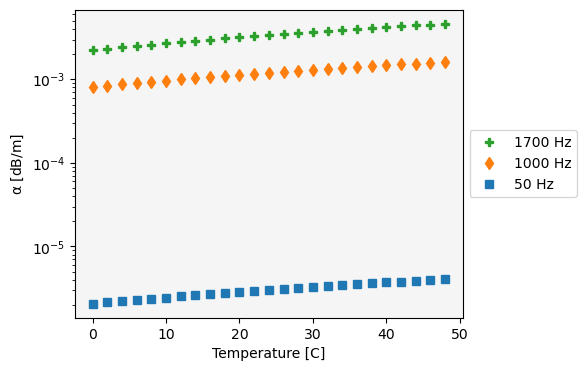

In [90]:
my_freq = 50  # https://doi.org/10.2514/6.2024-3398 figure 9

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

markers = ["s", "d", "P"]

for idx, j in enumerate(
    [
        50,
        # 150,
        # 500,
        1000,
        1700,
    ]
):

    air_absorption_coefficients = []

    for i in range(50):
        air_absorption_coefficients.append(
            air_absorption_coefficient(
                frequency=j,
                temperature_K=i + scipy.constants.zero_Celsius,
                pressure_Pa=101325,
                relative_humidity_percent=50,
            )
        )

    ax.plot(
        np.arange(50)[::2],
        air_absorption_coefficients[::2],
        marker=markers[idx],
        label=str(j) + " Hz",
        linestyle="",
    )

    ax.legend(reverse=True, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    ax.set_facecolor("whitesmoke")
    ax.set_xlabel("Temperature [C]")
    # ax.set_ylabel("Frequency [Hz]")
    ax.set_ylabel(r"$\mathrm{\alpha\ [dB/m]}$")


plt.show();

In [91]:
n = 2  # Exponent of noise fall off, 1/r^n


# Function to calculate noise level in decibels at a
# given distance from a point source considering air temperature
def noise_level_at_distance(source_level, distance, my_temperature_in_K):

    absorption_coefficient = air_absorption_coefficient(
        frequency=my_freq,
        temperature_K=my_temperature_in_K,
        pressure_Pa=scipy.constants.atm,
        relative_humidity_percent=50,
    )

    return (
        source_level - 10 * n * np.log10(distance) - absorption_coefficient * distance
    )

# Following cell gives 'parameters' used by Papermill for batch processing.

In [92]:
# Parameter cell for papermill


airport_code = "EGLL"
model = "ACCESS-ESM1-5"
batch = False
_2030 = False
measure = "mean"

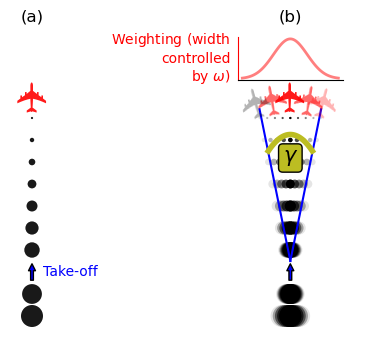

In [93]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
)

fig.set_figheight(4)
fig.set_figwidth(10)

for i in np.arange(10):
    if i == 2:
        facecolor = "none"
    else:
        facecolor = "k"

    axes.flatten()[0].add_patch(
        Ellipse(
            (0, i - 1),
            width=1 - i / 10,
            height=1 - i / 10,
            alpha=0.9,
            facecolor=facecolor,
            edgecolor="none",
        )
    )

axes.flatten()[0].set_xlim(-1, 1)
axes.flatten()[0].set_ylim(-2, 10)
axes.flatten()[0].set_aspect("equal")

axes.flatten()[0].add_patch(
    patches.FancyArrowPatch(
        (0, 0.5), (0, 1.5), mutation_scale=10, facecolor="b", zorder=10, edgecolor="k"
    )
)
for i in np.arange(10):
    for j, alpha in enumerate([0.9, 0.7, 0.5, 0.3, 0.1]):
        if i == 2:
            facecolor = "none"

        else:
            facecolor = "k"

        offset = (i - 2) * 0.05 * j
        # print(offset)
        axes.flatten()[1].add_patch(
            Ellipse(
                (offset, i - 1),
                width=1 - i / 10,
                height=1 - i / 10,
                alpha=alpha,
                facecolor=facecolor,
                edgecolor="none",
            )
        )
        axes.flatten()[1].add_patch(
            Ellipse(
                (-offset, i - 1),
                width=1 - i / 10,
                height=1 - i / 10,
                alpha=alpha,
                facecolor=facecolor,
                edgecolor="none",
            )
        )

axes.flatten()[1].set_xlim(-3, 3)
axes.flatten()[1].set_ylim(-2, 10)
axes.flatten()[1].set_aspect("equal")

axes.flatten()[1].add_patch(
    patches.FancyArrowPatch(
        (0, 0.5), (0, 1.5), mutation_scale=10, facecolor="b", zorder=10, edgecolor="k"
    )
)

plt.subplots_adjust(wspace=-0.5)

# for ax in axes.flatten():
#     ax.axis('off')

axes.flatten()[0].text(
    0.25,
    9,
    "✈️",
    fontsize=30,
    ha="center",
    va="center",
    rotation=90,
    alpha=0.9,
    color="r",
)

axes.flatten()[1].text(
    0.23,
    9,
    "✈️",
    fontsize=30,
    ha="center",
    va="center",
    rotation=90,
    alpha=0.9,
    color="r",
)

axes.flatten()[1].text(
    1.08,
    8.8,
    "✈️",
    fontsize=30,
    ha="center",
    va="center",
    rotation=80,
    alpha=0.6,
    color="r",
)

axes.flatten()[1].text(
    1.7,
    8.7,
    "✈️",
    fontsize=30,
    ha="center",
    va="center",
    rotation=75,
    alpha=0.3,
    color="r",
)

axes.flatten()[1].text(
    -0.62,
    8.9,
    "✈️",
    fontsize=30,
    ha="center",
    va="center",
    rotation=100,
    alpha=0.6,
    color="r",
)
axes.flatten()[1].text(
    -1.32,
    8.8,
    "✈️",
    fontsize=30,
    ha="center",
    va="center",
    rotation=105,
    alpha=0.3,
    color="k",
)

axes.flatten()[0].text(0.5, 1, "Take-off", va="center", color="b")


inset_ax = inset_axes(
    axes.flatten()[1],
    width="80%",
    height="14%",
    loc="upper center",
)
x = np.linspace(-2, 2, 100)
inset_ax.plot(x, np.exp(-(x**2)), color="r", linewidth=2, alpha=0.5)

# inset_ax.fill_between(x, 0, np.exp(-x**2), where=(x >= -1/np.sqrt(2)) & (x <= 1/np.sqrt(2)),
#                       color='gray', alpha=0.5)


inset_ax.patch.set_alpha(0.5)
# inset_ax.axis('off')
# Hide the top, right, and bottom spines
inset_ax.spines["top"].set_visible(False)
inset_ax.spines["right"].set_visible(False)
# inset_ax.spines['bottom'].set_visible(False)
inset_ax.spines["left"].set_color("red")
inset_ax.yaxis.label.set_color("red")
inset_ax.tick_params(axis="y", colors="red")
inset_ax.set_ylabel(
    r"$\mathrm{Weighting}$" + " (width\ncontrolled\n" + r"$\mathrm{by\ }\omega)$",
    ha="right",
    rotation=0,
    labelpad=5,
    va="center",
)

# Hide the x-axis
inset_ax.xaxis.set_visible(False)
inset_ax.set_yticks([])


for ax in axes.flatten():
    ax.axis("off")

axes.flatten()[1].plot([0, 1.4], [1.5, 8.4], "b")
axes.flatten()[1].plot([0, -1.4], [1.5, 8.4], "b")


def bezier_curve(t, points):
    n = len(points) - 1
    curve = np.zeros((len(t), 2))
    for i in range(n + 1):
        curve += np.outer(
            (math.factorial(n) / (math.factorial(i) * math.factorial(n - i)))
            * (t**i)
            * ((1 - t) ** (n - i)),
            points[i],
        )
    return curve


points = np.array([[-1, 6.5], [0, 8], [1, 6.5]])

t = np.linspace(0, 1, 100)

curve = bezier_curve(t, points)
axes.flatten()[1].plot(
    curve[:, 0], curve[:, 1], label="Bezier Curve", color="tab:olive", linewidth=4
)

axes.flatten()[0].set_ylim(-2, 12)
axes.flatten()[1].set_ylim(-2, 12)
axes.flatten()[1].text(
    0,
    6.0,
    r"$\gamma$",
    ha="center",
    fontsize=15,
    bbox=dict(facecolor="tab:olive", edgecolor="black", boxstyle="round,pad=0.2"),
)


axes.flatten()[0].set_title("(a)")
axes.flatten()[1].set_title("(b)")


plt.show();

In [94]:
latitude = airport_coordinates[airport_code][0]
longitude = airport_coordinates[airport_code][1]

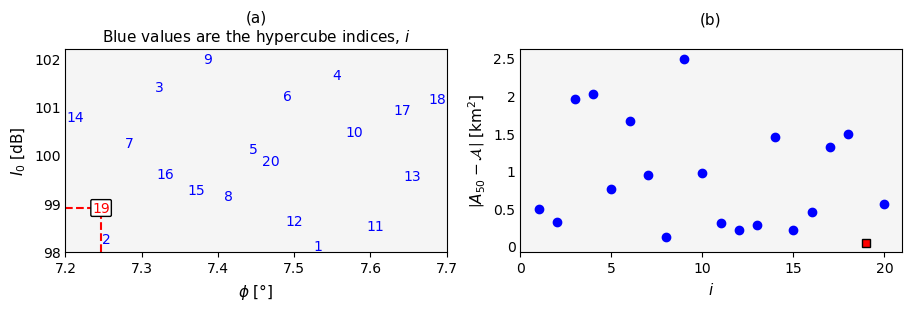

In [95]:
# Define the number of samples and dimensions
n_samples = 20
n_dimensions = 2

# Create a Latin Hypercube sampler with a fixed seed for reproducibility
sampler = qmc.LatinHypercube(d=n_dimensions, seed=42)

# Generate the samples
latin_hypercube = sampler.random(n=n_samples)

# Scale the samples to the specified ranges
lhc_angles = [7.2, 7.7]
lhc_I0s = [98, 102]
scaled_latin_hypercube = qmc.scale(
    latin_hypercube, [lhc_angles[0], lhc_I0s[0]], [lhc_angles[1], lhc_I0s[1]]
)

# print(scaled_latin_hypercube)

fig, axes = plt.subplots(nrows=1, ncols=2, layout="constrained")

fig.set_figheight(3)
fig.set_figwidth(9)


axes = axes.flatten()


_y = abs(
    np.array(
        [
            4.279905541050282,
            4.453134614600564,
            6.72201772098974,
            6.79204855005619,
            5.523855089869113,
            6.431056520783372,
            5.710687927515279,
            4.894537795514078,
            7.264511821801272,
            5.740808504662196,
            4.469047345590512,
            4.5547857147984985,
            5.044139099501314,
            6.22741753960603,
            4.980632033442813,
            5.220566718961662,
            6.084418225711636,
            6.2643250117289675,
            4.816017787995326,
            5.332519484282039,
        ]
    )
    - 4.77
)

for i in range(n_samples):
    if i == np.argmin(_y):
        color = "r"
        bbox = dict(facecolor="w", edgecolor="black", boxstyle="round,pad=0.1")
    else:
        color = "b"
        bbox = None
    axes[0].scatter(
        scaled_latin_hypercube[i][0],
        scaled_latin_hypercube[i][1],
        edgecolors="none",
        facecolors="none",
    )
    axes[0].text(
        scaled_latin_hypercube[i][0],
        scaled_latin_hypercube[i][1],
        str(i + 1),
        ha="center",
        va="center",
        color=color,
        bbox=bbox,
    )


axes[1].plot(
    np.delete(np.arange(n_samples) + 1, np.argmin(_y)),
    np.delete(_y, np.argmin(_y)),
    "ob",
    # color=[0,0,1,0.2], markeredgecolor = 'k'
)
axes[1].plot(
    (np.arange(n_samples) + 1)[np.argmin(_y)],
    _y[np.argmin(_y)],
    "sr",
    # color=[1,0,0,0.2],
    markeredgecolor="k",
)

axes[1].set_xticks([0, 5, 10, 15, 20])

[ax.set_facecolor("whitesmoke") for ax in axes]

titles = [
    "(a)\nBlue values are the hypercube indices, " + r"$i$",
    "(b)\n",
]
xlabels = [
    r"$\phi$" + " [" + r"$\degree$" + "]",
    r"$i$",
    r"$\phi$" + " [" + r"$\degree$" + "]",
]

[ax.set_title(title, fontsize=11) for ax, title in zip(axes, titles)]
[ax.set_xlabel(xlabels, fontsize=11) for ax, xlabels in zip(axes, xlabels)]

axes[0].set_ylabel(
    r"$I_{0}$" + " [dB]",
    fontsize=11,
)
axes[1].set_ylabel(
    r"$\left|A_{50}-\mathcal{A}\right|$" + " [km" + r"$^2$" + "]",
    fontsize=11,
    # rotation=0,
    # labelpad=25,
)
axes[0].vlines(
    x=scaled_latin_hypercube[np.argmin(_y)][0],
    ymin=98,
    ymax=scaled_latin_hypercube[np.argmin(_y)][1],
    colors="r",
    linestyles="dashed",
)

axes[0].hlines(
    y=scaled_latin_hypercube[np.argmin(_y)][1],
    xmin=7.2,
    xmax=scaled_latin_hypercube[np.argmin(_y)][0],
    colors="r",
    linestyles="dashed",
)

axes[0].set_ylim(bottom=lhc_I0s[0])

[ax.yaxis.set_major_formatter(FormatStrFormatter("%g")) for ax in axes]

[ax.tick_params(axis="y", which="both", length=0) for ax in axes]


# axes[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])


[ax.set_xlim(7.2, 7.7) for ax in [axes[0]]]


plt.show();

In [96]:
# new values

optimum_climb_angle = scaled_latin_hypercube[np.argmin(_y)][0]
optimum_climb_angle
optimum_source_level = scaled_latin_hypercube[np.argmin(_y)][1]
optimum_source_level

np.float64(7.246751962366614)

np.float64(98.90485901475482)

  0%|                                                                                                            | 0/4 [00:00<?, ?it/s]

"\nfor the 'cs =' call immediately below, if you use contour (not contourf) \nthen the are calculated explicitly depends on the contour levels used but for contourf\nit only depends on the smallest one!\n    "

I0=98.90485901475482

angle =7.246751962366614

Total area enclosed by the contour: 5.52 square km.

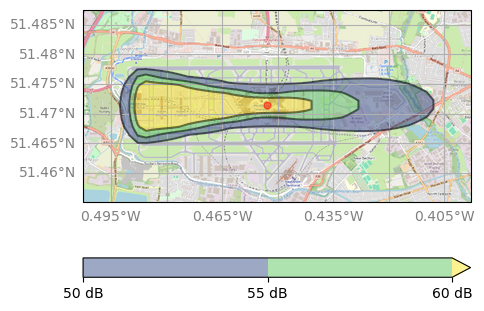

 25%|█████████████████████████                                                                           | 1/4 [00:05<00:15,  5.07s/it]

"\nfor the 'cs =' call immediately below, if you use contour (not contourf) \nthen the are calculated explicitly depends on the contour levels used but for contourf\nit only depends on the smallest one!\n    "

I0=98.90485901475482

angle =7.246751962366614

Total area enclosed by the contour: 5.57 square km.

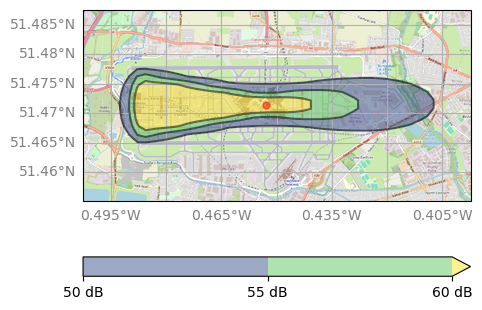

 50%|██████████████████████████████████████████████████                                                  | 2/4 [00:09<00:09,  4.74s/it]

"\nfor the 'cs =' call immediately below, if you use contour (not contourf) \nthen the are calculated explicitly depends on the contour levels used but for contourf\nit only depends on the smallest one!\n    "

I0=98.90485901475482

angle =7.246751962366614

Total area enclosed by the contour: 5.57 square km.

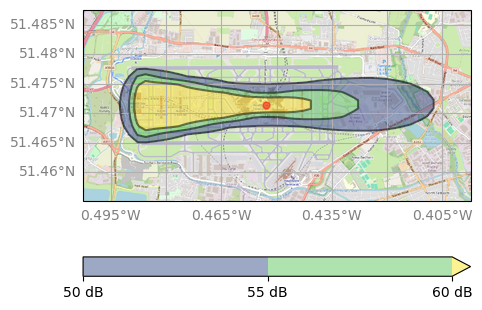

 75%|███████████████████████████████████████████████████████████████████████████                         | 3/4 [00:14<00:04,  4.69s/it]

"\nfor the 'cs =' call immediately below, if you use contour (not contourf) \nthen the are calculated explicitly depends on the contour levels used but for contourf\nit only depends on the smallest one!\n    "

I0=98.90485901475482

angle =7.246751962366614

Total area enclosed by the contour: 5.62 square km.

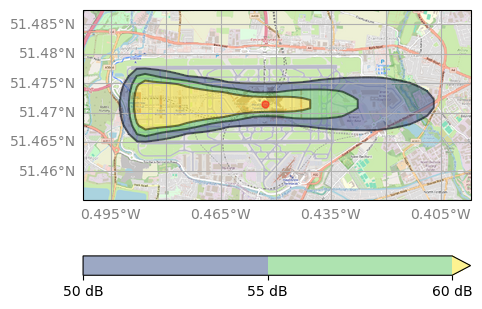

In [97]:
areas = {}

runway_length = runway_lengths[airport_code]

maximum_takeoff_distance = 2362  # Gratton et al. suppl. #2

total_areas = []

css = {}

if runway_length > maximum_takeoff_distance:
    takeoff_distance = maximum_takeoff_distance

else:
    takeoff_distance = runway_length

# Coordinates for Chios Airport
latitude = airport_coordinates[airport_code][0]
longitude = airport_coordinates[airport_code][1]
runway_bearing = runway_bearings[airport_code]  # Degrees
ac = "a320"

J_maxs = {}

climb_angle_adjustments = {}

Tvar = "mx2t24"

contours_dict = {}

# for idy in tqdm(range(n_samples), leave=False):

for period in tqdm(periods, leave=False):
    # for period in tqdm(["historical"], leave=False):

    obj = pd.read_pickle(
        "~/jupyter/"
        + "pickles-"
        + ac
        + "/vars_"
        + model
        + "_"
        + airport_code
        + "_JJA"
        + "_2030" * (_2030 == True)
        + ".pkl"
    )
    if measure == "mean":
        density = (obj["sp_" + period] / (Rspecific * obj[Tvar + "_" + period])).mean()
        my_temperature_in_K = (obj["t2m_" + period]).mean()

    elif measure == "min":
        density = (obj["sp_" + period] / (Rspecific * obj[Tvar + "_" + period])).min()
    elif measure == "max":
        density = (obj["sp_" + period] / (Rspecific * obj[Tvar + "_" + period])).max()
    elif measure.startswith("p"):
        density = np.percentile(
            (obj["sp_" + period] / (Rspecific * obj[Tvar + "_" + period])).compressed(),
            int(measure[1:]),
        )
        print("measure is " + str(int(measure[1:])))

    runway_multiple_frame = 5  # Size of half of entire region of interest

    # Create a grid of distances in 2D space.
    # This is the *entire* area over which contours will be calculated.
    x = np.linspace(
        -runway_multiple_frame * runway_length,
        runway_multiple_frame * runway_length,
        250,
    )
    y = np.linspace(
        -runway_multiple_frame * runway_length,
        runway_multiple_frame * runway_length,
        250,
    )
    X, Y = np.meshgrid(x, y)

    m_in_deg_at_equator = 111320  # Metres in one degree of arc at equator!!

    # Convert to degrees
    X_deg = X / (m_in_deg_at_equator * np.cos(np.radians(latitude))) + longitude
    Y_deg = Y / m_in_deg_at_equator + latitude

    noise_levels_array = []

    size_of_source_array = 400

    source_xs = np.zeros(size_of_source_array)
    source_ys = np.linspace(
        -takeoff_distance,  # centre of whole grid is where take-off happens
        y.max(),
        size_of_source_array,
    )

    ##################################################################

    # https://eng.libretexts.org/Bookshelves/Aerospace_Engineering/
    # Aerodynamics_and_Aircraft_Performance_3e_%28Marchman%29/05%3A_Altitude_Change-_Climb_and_Guide
    # https://pressbooks.lib.vt.edu/aerodynamics/chapter/chapter-5-altitude-change-climb-and-guide/

    climb_angle1_0 = optimum_climb_angle
    # climb_angle1_0 = scaled_latin_hypercube[idy][0]
    # climb_angle1_0 = 7.7

    climb_angle1 = math.degrees(
        math.asin(
            density
            / (
                obj["sp_" + "historical"] / (Rspecific * obj[Tvar + "_" + "historical"])
            ).mean()
            * math.sin(math.radians(climb_angle1_0))
        )
    )

    climb_angle_adjustments[period] = climb_angle1 / climb_angle1_0

    climb_angle2_0 = optimum_climb_angle
    # climb_angle2_0 = scaled_latin_hypercube[idy][0]
    # climb_angle2_0 = 7.7

    climb_angle2 = math.degrees(
        math.asin(
            density
            / (
                obj["sp_" + "historical"] / (Rspecific * obj[Tvar + "_" + "historical"])
            ).mean()
            * math.sin(math.radians(climb_angle2_0))
        )
    )

    ##################################################################

    source_level1 = optimum_source_level
    # source_level1 = scaled_latin_hypercube[idy][1]
    # source_level1 = 100

    source_level2 = optimum_source_level
    # source_level2 = scaled_latin_hypercube[idy][1]
    # source_level2 = 100

    source_zs = [
        -takeoff_distance * math.tan(math.radians(climb_angle1))
    ]  # First element

    if takeoff_distance > runway_length:
        sys.exit(
            "Take-off distance, "
            + str(takeoff_distance)
            + " is longer than the runway length, "
            + str(runway_length)
        )

    source_levels = [source_level1]

    for i in range(len(source_ys) - 1):
        if source_zs[-1] / 0.3048 < 3000:
            _climb_angle = climb_angle1
        else:
            _climb_angle = climb_angle2

        source_zs.append(
            source_zs[-1]
            + (source_ys[i + 1] - source_ys[i]) * math.tan(math.radians(_climb_angle))
        )

        if source_zs[-1] / 0.3048 < 800:
            source_levels.append(source_level1)
        else:
            source_levels.append(source_level2)

    source_zs = np.array(source_zs)
    source_zs[source_zs < 0] = 0

    source_levels = np.array(source_levels, dtype=float)
    sigma = 2
    source_levels = gaussian_filter1d(source_levels, sigma)

    for i in range(len(source_xs)):
        source_x = source_xs[i]
        source_y = source_ys[i]
        source_z = source_zs[i]

        distance_between_sources = 11.2e0
        # distance_between_sources = 11.2e0*10
        # distance_between_sources = 11.2e0*20

        distances1 = np.sqrt(
            (X - (source_x - distance_between_sources / 2)) ** 2
            + (Y - source_y) ** 2
            + np.maximum(source_z, 0) ** 2
        )

        distances2 = np.sqrt(
            (X - (source_x + distance_between_sources / 2)) ** 2
            + (Y - source_y) ** 2
            + np.maximum(source_z, 0) ** 2
        )

        # Calculate noise levels at each point in the grid considering air density
        noise_levels_array.append(
            10
            * np.log10(
                10
                ** (
                    noise_level_at_distance(
                        source_levels[i], distances1, my_temperature_in_K
                    )
                    / 10
                )
                + 10
                ** (
                    noise_level_at_distance(
                        source_levels[i], distances2, my_temperature_in_K
                    )
                    / 10
                )
            )
        )

    J = np.max(noise_levels_array, axis=0)

    if airport_code == "LGHI":
        fig, (ax1, ax2) = plt.subplots(
            nrows=1, ncols=2, subplot_kw={"projection": ccrs.Mercator()}
        )
        fig.set_figwidth(10)
    else:
        fig, ax1 = plt.subplots(
            nrows=1, ncols=1, subplot_kw={"projection": ccrs.Mercator()}
        )
        fig.set_figwidth(5)

    theta = 10
    _2sigma2 = 45**2

    Js = []

    steps = 100

    angles = np.linspace(-theta, theta, steps)

    weights = np.exp(-(angles**2) / _2sigma2)
    # weights = np.ones(len(angles))

    for i in range(steps):
        Js.append(scipy.ndimage.rotate(J * weights[i], angles[i], reshape=False))

    J_max = np.max(Js, axis=0)

    # J_max_rotated = scipy.ndimage.rotate(J_max, runway_bearing , reshape=False)

    J_maxs[period] = J_max

    request = cimgt.OSM()

    offsets_padhra = [
        -0.0625,
        0.08,
        -0.025,
        0.08,
    ]  # longitude min, max, latitude min, max

    if airport_code == "LGHI":
        offsets = copy.deepcopy(offsets_padhra)

    else:
        offsets = [-0.0625, 0.0625, -0.0625, 0.0625]

    extent = [
        longitude + offsets[0],
        longitude + offsets[1],
        latitude + offsets[2],
        latitude + offsets[3],
    ]

    ax1.set_extent(extent, crs=ccrs.PlateCarree())

    level = 14  # Level of detail in background map

    ax1.add_image(request, level, interpolation="spline36", alpha=1)

    # Add gridlines with labels
    gl = ax1.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 10, "color": "gray"}
    gl.ylabel_style = {"size": 10, "color": "gray"}

    X_deg_rotated = scipy.ndimage.rotate(X_deg, -runway_bearing, reshape=False)
    Y_deg_rotated = scipy.ndimage.rotate(Y_deg, -runway_bearing, reshape=False)

    Lden = False

    if Lden:
        J_max = 10 * np.log10(
            1
            / 24
            * (
                12 * 10 ** (J_max / 10)
                + 4 * 10 ** ((J_max + 5) / 10)
                + 8 * 10 ** ((J_max + 10) / 10)
            )
        )

    # contour_for_area_calculation = [
    #     50,
    # ]
    contour_for_area_calculation = [
        50,
        55,
        60,
    ]

    """
for the 'cs =' call immediately below, if you use contour (not contourf) 
then the are calculated explicitly depends on the contour levels used but for contourf
it only depends on the smallest one!
    """

    cs = ax1.contourf(
        X_deg_rotated,
        Y_deg_rotated,
        J_max,
        levels=contour_for_area_calculation,
        # cmap='viridis_r',
        # colors = ['k','b','r'],
        # linestyles='--',
        alpha=0.5,
        transform=ccrs.PlateCarree(),
        extend="max",
    )

    cs2 = ax1.contour(
        X_deg_rotated,
        Y_deg_rotated,
        J_max,
        levels=contour_for_area_calculation,
        colors=["k"],
        # linestyles='--',
        alpha=0.5,
        transform=ccrs.PlateCarree(),
        # extend='max'
    )

    if len(contour_for_area_calculation) > 1:

        cbar = plt.colorbar(cs, orientation="horizontal")

        # Get current ticks
        ticks = cbar.get_ticks()

        # Set fixed locator and formatter with ' dB' appended
        cbar.locator = ticker.FixedLocator(ticks)
        cbar.formatter = ticker.FixedFormatter([f"{tick:g} dB" for tick in ticks])
        cbar.update_ticks()

    css[period] = cs

    ###########################################################
    # Extract contour paths

    if airport_code != "LGHI":
        paths = cs.get_paths()

        # Initialize bounds
        lon_min, lon_max = float("inf"), float("-inf")
        lat_min, lat_max = float("inf"), float("-inf")

        # Calculate bounds based on contour paths
        for path in paths:
            vertices = path.vertices
            lon_min = min(lon_min, vertices[:, 0].min())
            lon_max = max(lon_max, vertices[:, 0].max())
            lat_min = min(lat_min, vertices[:, 1].min())
            lat_max = max(lat_max, vertices[:, 1].max())

        buffer = 0.01  # Approximately 1km
        lon_min -= buffer
        lon_max += buffer
        lat_min -= buffer
        lat_max += buffer

        # Set extent
        ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ###########################################################

    ax1.plot(
        longitude,
        latitude,
        marker="o",
        color="red",
        markersize=5,
        alpha=0.5,
        transform=ccrs.PlateCarree(),
    )

    # ax1.set_title(
    #     r"$\alpha=$"
    #     + str(
    #         get_alpha_for_temperature(
    #             my_temperature_in_K - scipy.constants.zero_Celsius
    #         )
    #     )
    # )

    if airport_code == "LGHI":
        ax2.remove()
        ax2 = fig.add_subplot(122)
        ax2.imshow(mpimg.imread("./image.png"), aspect="auto")
        ax2.axis("off")
        ax2.set_frame_on(False)
    else:
        pass

    paths = cs.get_paths()

    geod = Geod(ellps="WGS84")

    def calculate_geodetic_area(path):
        vertices = path.vertices
        lons, lats = vertices[:, 0], vertices[:, 1]
        poly = Polygon(vertices)
        area, _ = geod.geometry_area_perimeter(poly)
        return area

    total_area = sum(calculate_geodetic_area(path) for path in paths)

    print("I0=" + str(source_level1))
    print("angle =" + str(climb_angle1_0))

    print(f"Total area enclosed by the contour: {total_area / 1e6:.2f} square km.")

    total_areas.append(total_area / 1e6)

    areas[period] = total_area

    # ax2.remove()

    save_contours = False

    if save_contours:
        contours_dict[
            "X_deg_rotated_"
            + airport_code
            + "_"
            + model
            + "_2030" * (_2030 == True)
            + "_"
            + period
        ] = X_deg_rotated

        contours_dict[
            "Y_deg_rotated_"
            + airport_code
            + "_"
            + model
            + "_2030" * (_2030 == True)
            + "_"
            + period
        ] = Y_deg_rotated

        contours_dict[
            "J_max_"
            + airport_code
            + "_"
            + model
            + "_2030" * (_2030 == True)
            + "_"
            + period
        ] = J_max

        filename = airport_code + "_" + model + "_2030" * (_2030 == True) + ".pkl"

        if not os.path.exists("contours"):
            os.makedirs("contours")

        with open("./contours/" + filename, "wb") as file:
            pickle.dump(contours_dict, file)

    plt.show()

In [98]:
(obj["mx2t24_" + "historical"]).mean() - scipy.constants.zero_Celsius
(obj["sp_" + "historical"]).mean()

np.float64(20.064945652173947)

np.float64(101910.67826086956)

In [99]:
df = pd.DataFrame(list(climb_angle_adjustments.items()), columns=["Key", "Value"])

if not os.path.exists("climb_angle_adjustments"):
    os.makedirs("climb_angle_adjustments")

df.to_csv(
    "climb_angle_adjustments/climb_angle_adjustments_"
    + measure
    + "_"
    + airport_code
    + "_"
    + model
    + "_2030" * (_2030 == True)
    + ".csv",
    index=False,
    header=True,
)

In [100]:
areas

{'historical': 5518502.042597856,
 'ssp126': 5570830.433052133,
 'ssp370': 5572847.373017876,
 'ssp585': 5616291.665753313}

In [101]:
areas

for period in periods:
    areas[period + "_percentage_change_cf_historical"] = (
        (areas[period] - areas["historical"]) / areas["historical"] * 100
    )

areas

{'historical': 5518502.042597856,
 'ssp126': 5570830.433052133,
 'ssp370': 5572847.373017876,
 'ssp585': 5616291.665753313}

{'historical': 5518502.042597856,
 'ssp126': 5570830.433052133,
 'ssp370': 5572847.373017876,
 'ssp585': 5616291.665753313,
 'historical_percentage_change_cf_historical': 0.0,
 'ssp126_percentage_change_cf_historical': 0.9482354097243872,
 'ssp370_percentage_change_cf_historical': 0.984784095403483,
 'ssp585_percentage_change_cf_historical': 1.7720320188451382}

In [102]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(areas.items()), columns=["Key", "Value"])

if not os.path.exists("areas"):
    os.makedirs("areas")

# Write DataFrame to a CSV file in the "areas" directory
df.to_csv(
    "areas/areas_"
    + measure
    + "_"
    + airport_code
    + "_"
    + model
    + "_2030" * (_2030 == True)
    + ".csv",
    index=False,
    header=True,
)

# Quit here if running batches on a remote server using Papermill.

In [103]:
if batch:
    print("Running batch jobs with papermill, exiting here.")
    sys.exit(0)

In [104]:
show_illustration_of_parameter_changes = True

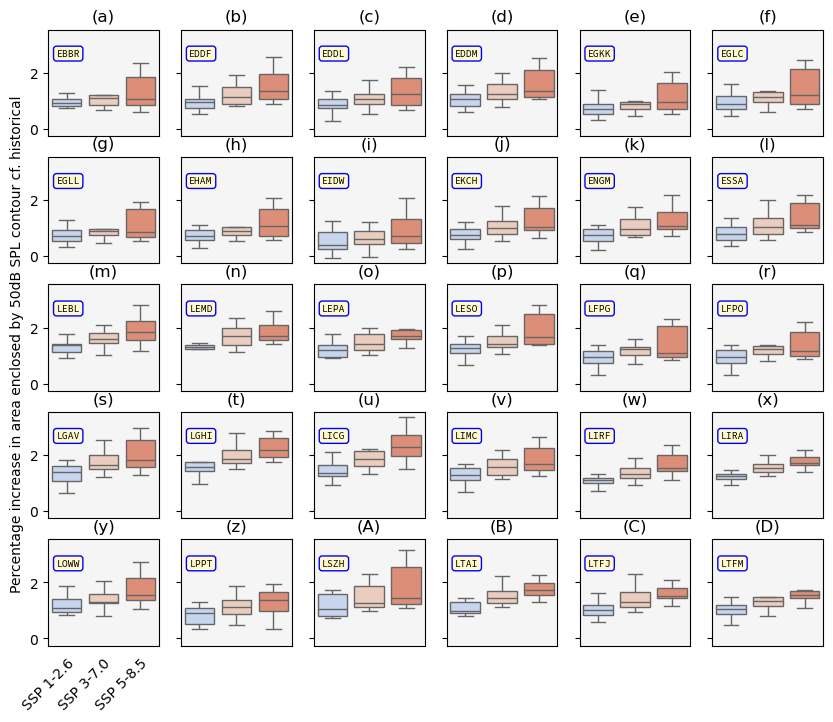

In [105]:
fig, axes = plt.subplots(nrows=5, ncols=6, sharey=1)
fig.set_figwidth(10)
fig.set_figheight(8)

# Directory containing the CSV files
directory = "areas"


for idx, _airport_code in enumerate(airport_codes):
    # Initialize an empty list to store dataframes
    dataframes = []

    for filename in [
        filename
        for filename in os.listdir(directory)
        if (_airport_code in filename)
        and ("mean" in filename)
        and ("_2030" in filename if _2030 else "_2030" not in filename)
    ]:
        # if idx == 0:
        #     print(filename)
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes.append(df)

    # Concatenate all dataframes into a single dataframe
    combined_df = pd.concat(dataframes, ignore_index=True)

    mean_average_historical_area = combined_df[combined_df["Key"] == "historical"][
        "Value"
    ].mean()

    df_filtered = combined_df[combined_df["Key"].str.contains("percentage", case=False)]
    df_filtered = df_filtered[
        ~df_filtered["Key"].str.startswith(
            "hist",
        )
    ]

    labels = ["Historical", "SSP 1-2.6", "SSP 3-7.0", "SSP 5-8.5"]
    colors = sns.color_palette("coolwarm", n_colors=4)

    # Plot the data using seaborn
    # sns.boxplot(
    #     data=df_filtered,
    #     x="Key",
    #     y="Value",
    #     color="k",
    #     linewidth=1,
    #     alpha=0.5,
    #     ax=axes.flatten()[idx],
    #     facecolors="none",
    # )
    sns.boxplot(
        data=df_filtered,
        x="Key",
        y="Value",
        showfliers=False,
        hue="Key",
        palette=colors[1:],
        ax=axes.flatten()[idx],
        # inner=None,
        # cut=0,
    )
    axes.flatten()[idx].set_xticks(
        ticks=range(len(labels) - 1), labels=labels[1:], rotation=0
    )

    font = {"fontname": "Source Code Pro"}
    axes.flatten()[idx].text(
        0.075,
        0.75,
        _airport_code,
        transform=axes.flatten()[idx].transAxes,
        fontsize=7,
        **font,
        bbox=dict(
            facecolor="lemonchiffon",
            edgecolor="b",
            boxstyle="round,pad=0.3",
            linestyle="-",
        ),
    )

    if idx == 69:
        print(df_filtered)

    axes.flatten()[idx].set(xlabel=None)
    axes.flatten()[idx].set_facecolor("whitesmoke")
    axes.flatten()[idx].xaxis.set_ticks_position("none")
    axes.flatten()[idx].yaxis.set_major_formatter(FormatStrFormatter("%g"))

    if idx != 24:
        axes.flatten()[idx].set_xticklabels([])
        axes.flatten()[idx].set(ylabel=None)

    else:
        plt.setp(
            axes.flatten()[idx].get_xticklabels(),
            rotation=45,
            ha="right",
            rotation_mode="anchor",
        )

        axes.flatten()[idx].set_ylabel(
            "Percentage increase in area enclosed by "
            + "50dB SPL contour cf. historical",
            ha="left",
        )

    axes.flatten()[idx].set_title(
        "(" + list(string.ascii_lowercase + string.ascii_uppercase)[idx] + ")"
    )

plt.show();

In [106]:
airport_to_country = {
    "EBBR": "bel",
    "EDDF": "deu",
    "EDDL": "deu",
    "EDDM": "deu",
    "EGKK": "gbr",
    "EGLC": "gbr",
    "EGLL": "gbr",
    "EHAM": "nld",
    "EIDW": "irl",
    "EKCH": "dnk",
    "ENGM": "nor",
    "ESSA": "swe",
    "LEBL": "esp",
    "LEMD": "esp",
    "LEPA": "esp",
    "LESO": "esp",
    "LFPG": "fra",
    "LFPO": "fra",
    "LGAV": "grc",
    "LGHI": "grc",
    "LICG": "ita",
    "LIMC": "ita",
    "LIRF": "ita",
    "LIRA": "ita",
    "LOWW": "aut",
    "LPPT": "prt",
    "LSZH": "che",
    "LTAI": "tur",
    "LTFJ": "tur",
    "LTFM": "tur",
}

In [107]:
# Check ---> EGLC is London City so should be 'gbr'.
airport_to_country["EGLC"]

'gbr'

In [108]:
for _airport_code in airport_codes:
    file_name = str(airport_to_country[_airport_code]) + "*.tif"

In [109]:
population_densities = {}

In [110]:
# Define the discrete color levels
# levels = [0, 250, 500, 750, 1000]
levels = np.linspace(0, 500, 11)
levels = np.array(
    [
        0,
        25,
        50,
        75,
        100,
        150,
        200,
        250,
        300,
        350,
        400,
        450,
        500,
        750,
        1e3,
        1500,
        2000,
    ]
)

files = [
    "2635_worldpop_SSP1-RCP2.6_2014-01-01_2014-12-31_1year_mean.nc",
    "2634_worldpop_SSP1-RCP2.6_2050-01-01_2050-12-31_1year_mean.nc",
    "2639_worldpop_SSP3-RCP7_2050-01-01_2050-12-31_1year_mean.nc",
    "2638_worldpop_SSP5-RCP8_5_2050-01-01_2050-12-31_1year_mean.nc",
]


pop_density = {}

# Use the viridis colormap with 5 discrete colors
# cmap = plt.get_cmap("viridis", len(levels) - 1)


for idy, _file in enumerate(range(len(files))):

    # fig, axes = plt.subplots(
    #     nrows=5, ncols=6, subplot_kw={"projection": ccrs.PlateCarree()}
    # )
    # fig.set_figheight(10)
    # fig.set_figwidth(10)
    # axes = axes.flatten()

    for idx, _airport_code in tqdm(enumerate(airport_codes)):

        # extent = [
        #     airport_coordinates[_airport_code][1] - 0.0083 * 3,
        #     airport_coordinates[_airport_code][1] + 0.0083 * 3,
        #     airport_coordinates[_airport_code][0] - 0.0083 * 3,
        #     airport_coordinates[_airport_code][0] + 0.0083 * 3,
        # ]

        # lat_min = extent[2]
        # lat_max = extent[3]
        # lon_min = extent[0]
        # lon_max = extent[1]

        fpop = xr.open_dataset("~/noise/worldpop_future/" + files[idy])

        fpop = fpop.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

        # mesh = axes[idx].pcolormesh(
        #     fpop["lon"].squeeze(),
        #     fpop["lat"].squeeze(),
        #     fpop["pop_count"].squeeze(),
        #     cmap=cmap,
        #     norm=mcolors.BoundaryNorm(levels, cmap.N),
        #     transform=ccrs.PlateCarree(),
        #     alpha=0.75,
        # )

        # axes.flatten()[idx].add_feature(cfeature.LAND)
        # axes.flatten()[idx].add_feature(cfeature.OCEAN)
        # axes.flatten()[idx].add_feature(cfeature.BORDERS)

        area_of_extracted_region = (
            np.cos(np.radians(airport_coordinates[_airport_code][0]))
            * m_in_deg_at_equator
            * 0.0083
            * m_in_deg_at_equator
            * 0.0083
            / 1e6
            * len(fpop["lon"])
            * len(fpop["lat"])
        )

        # Sum the population count
        pop_density[_airport_code + "_" + periods[idy]] = (
            fpop["pop_count"].squeeze().sum().item() / area_of_extracted_region
        )

        # axes.flatten()[idx].set_title(
        #     "("
        #     + list(string.ascii_lowercase + string.ascii_uppercase)[idx]
        #     + ") "
        #     + _airport_code
        #     + ", "
        #     # + str(int(round(pop_density, -3))),
        #     f"{int(round(pop_density[_airport_code + '_'+periods[idy]], -2)):,}",
        #     fontsize=7.5,
        # )

#     cbar = fig.colorbar(
#         mesh, ax=axes, orientation="horizontal", fraction=0.05, pad=0.1, extend="max"
#     )
#     cbar.set_ticks(levels)

#     plt.suptitle(str(periods[idy]))

# plt.show();

30it [00:00, 139.82it/s]
30it [00:00, 157.49it/s]
30it [00:00, 172.40it/s]
30it [00:00, 173.66it/s]


# Future population

In [111]:
%matplotlib inline

30it [00:00, 231.17it/s]


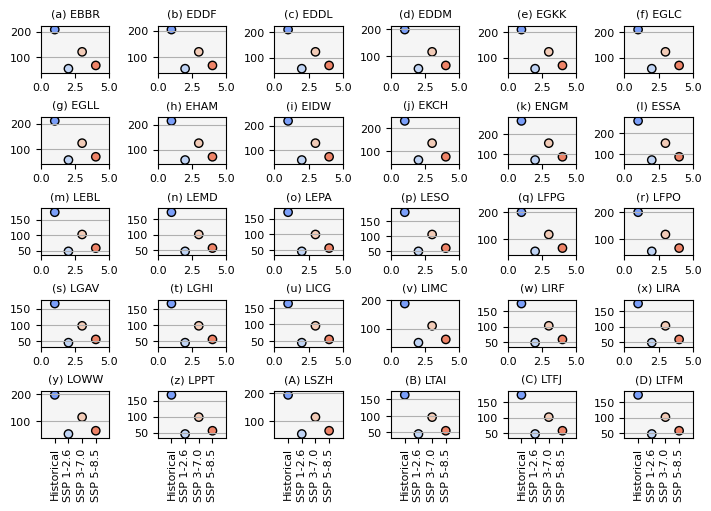

In [112]:
fig, axes = plt.subplots(
    nrows=5,
    ncols=6,
    # sharex=True,
    # sharey=True,
    layout="constrained",
)
fig.set_figheight(5)
fig.set_figwidth(7)
axes = axes.flatten()

for idx, _airport_code in tqdm(enumerate(airport_codes)):

    plotthis = np.array(
        list({k: v for k, v in pop_density.items() if _airport_code in k}.values())
    )

    axes[idx].scatter(
        [1, 2, 3, 4],
        # np.sign(plotthis) * np.log10(abs(plotthis)),
        plotthis,
        color=sns.color_palette("coolwarm", n_colors=4),
        edgecolor="k",
    )

    y_margin = (max(plotthis) - min(plotthis)) * 0.1  # 10% margin
    axes[idx].set_ylim(min(plotthis) - y_margin, max(plotthis) + y_margin)

    if idx >= 24:
        axes[idx].set_xticks([1, 2, 3, 4])
        axes[idx].set_xticklabels(labels, rotation=90)
    axes[idx].tick_params(axis="x", labelsize=8)
    axes[idx].tick_params(axis="y", labelsize=8)

    # else:
    #     axes[idx].set_xticks([])

    axes[idx].set(ylabel=None)
    axes[idx].set_xlim(0, 5)
    # axes[idx].set_yticks([1, 2, 3, 4])
    # axes[idx].set_yticklabels([r"$10$", r"$10^2$", r"$10^3$", r"$10^4$"])
    axes[idx].set_facecolor("whitesmoke")
    axes[idx].grid(axis="y")

    axes[idx].set_title(
        "("
        + list(string.ascii_lowercase + string.ascii_uppercase)[idx]
        + ") "
        + _airport_code,
        # + ", "
        # + str(int(population_density)),
        fontsize=8,
    )


# plt.suptitle("Base 10 logarithm of population density per km squared  ")

plt.show();

In [113]:
floats_only_dict = {}

# Directory containing the CSV files
directory = "areas"

for idx, _airport_code in enumerate(airport_codes):
    # Initialize an empty list to store dataframes
    dataframes = []

    for filename in [
        filename
        for filename in os.listdir(directory)
        if (_airport_code in filename)
        and ("mean" in filename)
        and ("_2030" in filename if _2030 else "_2030" not in filename)
    ]:

        df = pd.read_csv(os.path.join(directory, filename))
        dataframes.append(df)

    # Concatenate all dataframes into a single dataframe
    combined_df = pd.concat(dataframes, ignore_index=True)

    df_filtered = combined_df[
        ~combined_df["Key"].str.contains("percentage", case=False)
    ]

    df_filtered.loc[
        :, df_filtered.select_dtypes(include="number").columns
    ] /= 1e6  # m2 to km2

    labels = ["Historical", "SSP 1-2.6", "SSP 3-7.0", "SSP 5-8.5"]
    colors = sns.color_palette("coolwarm", n_colors=4)

    for idz, period in enumerate(periods):

        filtered_floats = df_filtered[
            df_filtered["Key"].str.startswith(period)
        ][  # absolute areas
            "Value"
        ]
        floats_only = filtered_floats[  #
            filtered_floats.apply(lambda x: isinstance(x, float))
        ]  # absolute areas for each model

        pop_density_filtered = {
            k: v for k, v in pop_density.items() if _airport_code in k and period in k
        }

        if period == "historical":
            value = list(pop_density_filtered.values())[
                0
            ]  # <--- persistent for 'historical' only

        else:

            pass

        # print(value)

        floats_only_dict[
            _airport_code + "_" + period + "_" + "population_at_" + str(my_freq) + "_Hz"
        ] = (
            floats_only * value
        )  # area * historical population density = total population assuming historical area

# Save the dictionary to a pickle file
with open(
    "./population_stats/" + "population_at_" + str(my_freq) + "_Hz",
    "wb",
) as f:
    pickle.dump(
        floats_only_dict, f
    )  # <--- what this is saving is the total population (absolute value)

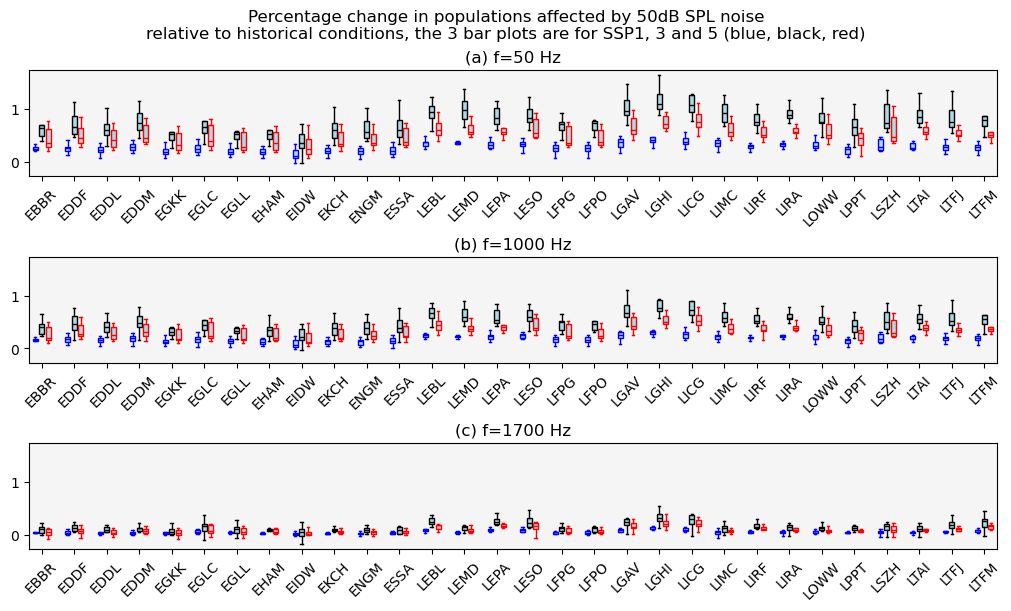

In [114]:
my_freqs = [
    50,
    1000,
    1700,
]

fig, axes = plt.subplots(
    nrows=len(my_freqs),
    ncols=1,
    # sharex=True,
    sharey=True,
    layout="constrained",
    figsize=(10, 6),
)

axes = axes.flatten()

for idf, _my_freq in enumerate(my_freqs):

    with open("./population_stats/population_at_" + str(_my_freq) + "_Hz", "rb") as f:
        obj = pickle.load(f)

    for idx, _airport_code in enumerate(airport_codes):

        for idz, period in enumerate(periods[1:]):

            boxplotcolors = copy.deepcopy(colors)
            boxplotcolors = ["b", "k", "r"]

            plotthis = (
                (
                    obj[
                        _airport_code
                        + "_"
                        + period
                        + "_"
                        + "population_at_"
                        + str(_my_freq)
                        + "_Hz"
                    ].values
                    - obj[
                        _airport_code
                        + "_"
                        + "historical"
                        + "_"
                        + "population_at_"
                        + str(_my_freq)
                        + "_Hz"
                    ].values
                )
                / obj[
                    _airport_code
                    + "_"
                    + "historical"
                    + "_"
                    + "population_at_"
                    + str(_my_freq)
                    + "_Hz"
                ].values
                * 100
            )

            take_population_change_into_account = True

            if take_population_change_into_account:
                plotthis = (
                    plotthis
                    * pop_density[_airport_code + "_" + period]
                    / pop_density[_airport_code + "_" + "historical"]
                )
            else:
                pass

            axes[idf].boxplot(
                plotthis,
                positions=[(idz + 1) + (5 * idx)],
                showfliers=False,
                widths=0.75,
                patch_artist=True,
                boxprops=dict(facecolor="lightblue", color=boxplotcolors[idz]),
                medianprops=dict(color=boxplotcolors[idz]),
                whiskerprops=dict(color=boxplotcolors[idz]),
                capprops=dict(color=boxplotcolors[idz]),
            )
    xticks = 2 + np.arange(0, 30) * 5
    axes[idf].set_xticks(xticks)
    axes[idf].set_xticklabels(airport_codes, rotation=45)
    axes[idf].set_xlim(0, xticks.max() + 2)

    axes[idf].set_title(
        f"({string.ascii_letters[idf]})" + " f=" + str(_my_freq) + " Hz"
    )

    axes[idf].set_facecolor("whitesmoke")


plt.suptitle(
    "Percentage change in populations affected by 50dB SPL noise\nrelative to historical conditions, "
    + "the 3 bar plots are for SSP1, 3 and 5 (blue, black, red)"
)

plt.show();

# next cell is just playing with the previous one but for abs values

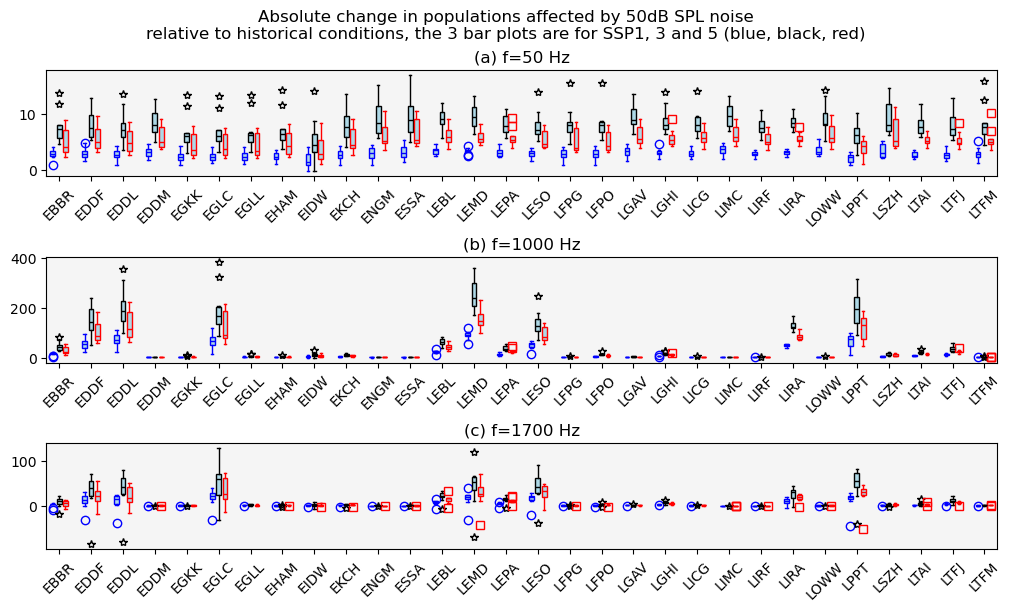

In [115]:
my_freqs = [
    50,
    # 150,
    # 500,
    1000,
    1700,
]

fig, axes = plt.subplots(
    nrows=len(my_freqs),
    ncols=1,
    # sharex=True,
    # sharey=True,
    layout="constrained",
    figsize=(10, 6),
)

axes = axes.flatten()

for idf, _my_freq in enumerate(my_freqs):

    with open("./population_stats/population_at_" + str(_my_freq) + "_Hz", "rb") as f:
        obj = pickle.load(f)

    for idx, _airport_code in enumerate(airport_codes):

        for idz, period in enumerate(periods[1:]):

            boxplotcolors = copy.deepcopy(colors)
            boxplotcolors = ["b", "k", "r"]

            plotthis = (
                obj[
                    _airport_code
                    + "_"
                    + period
                    + "_"
                    + "population_at_"
                    + str(_my_freq)
                    + "_Hz"
                ].values
                - obj[
                    _airport_code
                    + "_"
                    + "historical"
                    + "_"
                    + "population_at_"
                    + str(_my_freq)
                    + "_Hz"
                ].values
            )

            take_population_change_into_account = True

            if take_population_change_into_account:
                plotthis = (
                    plotthis
                    * pop_density[_airport_code + "_" + period]
                    / pop_density[_airport_code + "_" + "historical"]
                )
            else:
                pass

            axes[idf].boxplot(
                plotthis,
                positions=[(idz + 1) + (5 * idx)],
                # showfliers=False,
                widths=0.75,
                patch_artist=True,
                boxprops=dict(facecolor="lightblue", color=boxplotcolors[idz]),
                medianprops=dict(color=boxplotcolors[idz]),
                whiskerprops=dict(color=boxplotcolors[idz]),
                capprops=dict(color=boxplotcolors[idz]),
                flierprops=dict(
                    markeredgecolor=boxplotcolors[idz],
                    fillstyle="none",
                    marker=["o", "*", "s"][idz],
                ),
            )
    xticks = 2 + np.arange(0, 30) * 5
    axes[idf].set_xticks(xticks)
    axes[idf].set_xticklabels(airport_codes, rotation=45)
    axes[idf].set_xlim(0, xticks.max() + 2)

    axes[idf].set_title(
        f"({string.ascii_letters[idf]})" + " f=" + str(_my_freq) + " Hz"
    )

    axes[idf].set_facecolor("whitesmoke")


plt.suptitle(
    "Absolute change in populations affected by 50dB SPL noise\nrelative to historical conditions, "
    + "the 3 bar plots are for SSP1, 3 and 5 (blue, black, red)"
)

plt.show();

In [116]:
my_freq

50

In [117]:
models = [
    "ACCESS-ESM1-5",
    "CMCC-ESM2",
    "CNRM-ESM2-1",
    "CanESM5",
    "EC-Earth3",
    "GFDL-ESM4",
    "IPSL-CM6A-LR",
    "MPI-ESM1-2-LR",
    "NorESM2-LM",
    "UKESM1-0-LL",
]

# LESO angle adjustments

In [118]:
obj = pd.read_pickle(
    "~/jupyter/"
    + "pickles-"
    + ac
    + "/vars_"
    + "UKESM1-0-LL"
    + "_"
    + "LESO"
    + "_JJA"
    + "_2030" * (_2030 == False)
    + ".pkl"
)

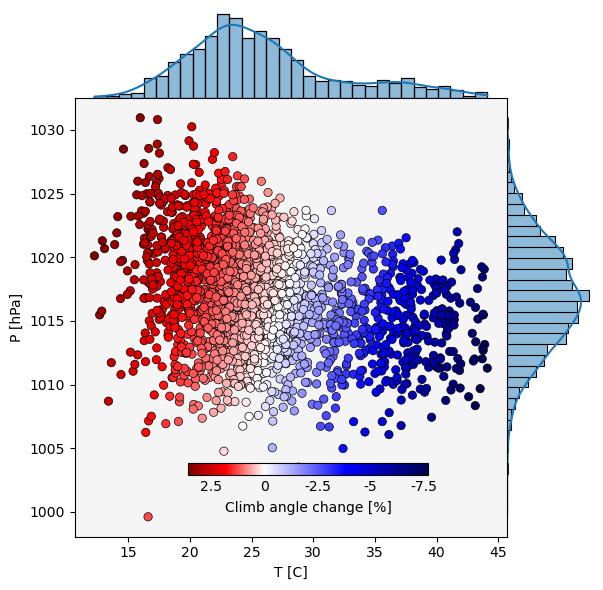

In [119]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

period = "ssp585"

_climb_angle = np.degrees(
    np.arcsin(
        (
            obj["sp_" + period].filled(np.nan).squeeze()
            / (Rspecific * obj[Tvar + "_" + period].filled(np.nan).squeeze())
        )
        / (
            obj["sp_" + "historical"].mean()
            / (Rspecific * obj[Tvar + "_historical"].mean())
        )
        * np.sin(np.radians(optimum_climb_angle))
    )
)

_climb_angle = (_climb_angle - optimum_climb_angle) / optimum_climb_angle * 100

df = pd.DataFrame(
    {
        "P": obj["sp_" + period].filled(np.nan).squeeze() / 1e2,
        "T": obj[Tvar + "_" + period].filled(np.nan).squeeze()
        - scipy.constants.zero_Celsius,
        "climb_angle": _climb_angle,
    }
)

# Define a threshold
threshold = climb_angle1_0

# Assign markers based on the threshold
df["marker"] = df["climb_angle"].apply(lambda y: "o" if y < threshold else "s")

df["marker"] = "o"

cmap = "icefire"
cmap = "Spectral"
cmap = "vlag"
cmap = "seismic"


for marker in df["marker"].unique():
    subset = df[df["marker"] == marker]

    edgecolor = "black" if marker == "o" else "w"

    g = sns.jointplot(
        data=df,
        x=subset["T"],
        y=subset["P"],
        marker=marker,
        hue="climb_angle",
        #      hue_norm=norm,
        # norm=norm,
        space=0,
        # size = 'climb_angle',sizes=(0,100),
        palette=cmap,
        # legend=marker=='o',
        edgecolor="k",
        legend=False,
        # edgecolor = edgecolor,
        # ax=ax
        # kind='reg'
        # marginal_kws=dict(fill=False)
    )

    g.ax_marg_x.clear()
    g.ax_marg_y.clear()

    sns.histplot(
        data=df,
        x=subset["T"],
        fill=True,
        ax=g.ax_marg_x,
        kde=True,
        # color='gold',
    )
    sns.histplot(
        data=df,
        y=subset["P"],
        fill=True,
        ax=g.ax_marg_y,
        kde=True,
        # color='gold',
    )

    g.ax_joint.set_facecolor("whitesmoke")

    g.ax_marg_x.xaxis.set_visible(False)
    g.ax_marg_x.yaxis.set_visible(False)
    g.ax_marg_y.xaxis.set_visible(False)
    g.ax_marg_y.yaxis.set_visible(False)

    # g.ax_marg_x.text(0.6,0.05,'occurrence frequency', transform=g.ax_marg_x.transAxes,
    #                 ha = 'right', )


plt.ylabel(
    "P [hPa]",
)
plt.xlabel(
    "T [C]",
)


# plt.gcf().set_facecolor('whitesmoke', )


norm = plt.Normalize(df["climb_angle"].min(), df["climb_angle"].max())

norm = TwoSlopeNorm(
    vmin=df["climb_angle"].min(), vcenter=0, vmax=df["climb_angle"].max()
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


cbar_ax = g.fig.add_axes([0.3, 0.2, 0.4, 0.02])


cbar = plt.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label(
    label="Climb angle change [%]", rotation=0, ha="center", va="center", labelpad=10
)
cbar.ax.tick_params(size=0)  # Hides the tick marks but keeps the labels

min_val = df["climb_angle"].min()
max_val = df["climb_angle"].max()


intermediate_vals = np.arange(np.ceil(min_val), np.floor(max_val) + 1)
cbar.set_ticks(intermediate_vals)


cbar.ax.set_xscale("linear")
cbar.ax.invert_xaxis()

cbar.ax.xaxis.set_major_formatter(FormatStrFormatter("%g"))


plt.show();